In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def criar_grafo_orientacao(caminho_arquivo):
    try:
        # Carregar os dados do arquivo CSV, especificando a codificação
        df = pd.read_csv(caminho_arquivo, sep=';', encoding='latin-1')

        # Selecionar apenas as colunas relevantes e remover linhas com dados faltantes
        colunas_necessarias = ['DiscenteID', 'OrientadorID', 'Unidade', 'Codigo_Projeto']
        df_limpo = df[colunas_necessarias].dropna()

        # Criando uma chave única para cada combinação de DiscenteID, OrientadorID e Codigo_Projeto
        df_limpo['chave_unica'] = df_limpo['DiscenteID'].astype(str) + '_' + df_limpo['OrientadorID'].astype(str) + '_' + df_limpo['Codigo_Projeto'].astype(str)

        # Remover duplicatas com base nesta chave única
        df_processado = df_limpo.drop_duplicates(subset=['chave_unica']).copy()

        # Criar o grafo
        G = nx.Graph()

        # Filtrando Orientadores, Departamentos e Discentes únicos
        orientadores = df_processado['OrientadorID'].unique()
        departamentos = df_processado['Unidade'].unique()
        discentes = df_processado['DiscenteID'].unique()

        # Adicionando os nós ao grafo
        G.add_nodes_from(orientadores, bipartite='orientador')
        G.add_nodes_from(departamentos, bipartite='departamento')
        G.add_nodes_from(discentes, bipartite='discente')

        # Adicionar as ligações (arestas) entre estudantes e orientadores
        for _, row in df_processado.iterrows():
            discente = row['DiscenteID']
            orientador = row['OrientadorID']
            G.add_edge(discente, orientador, tipo='orientacao')

        # Calcular e adicionar arestas entre orientadores e departamentos com peso
        pesos_orientador_departamento = df_processado.groupby(['OrientadorID', 'Unidade']).size().reset_index(name='peso')
        for _, row in pesos_orientador_departamento.iterrows():
            orientador = row['OrientadorID']
            unidade = row['Unidade']
            peso = row['peso']
            G.add_edge(orientador, unidade, peso=peso, tipo='afiliacao')

        # Imprimir informações sobre o grafo
        print(f"Número total de nós: {G.number_of_nodes()}")
        print(f"Número total de arestas: {G.number_of_edges()}")
        print(f"A densidade do grafo: {nx.density(G)}")
        return G

    except FileNotFoundError:
        print(f"Erro: O arquivo '{caminho_arquivo}' não foi encontrado. Verifique o nome e o caminho do arquivo.")
        return None
    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        return None

# Exemplo de como usar a função com o seu arquivo
caminho_do_seu_arquivo = "./Iniciação_Ciêntifica - Dados Abertos.csv"
grafo_final = criar_grafo_orientacao(caminho_do_seu_arquivo)

Número total de nós: 28212
Número total de arestas: 33618
A densidade do grafo: 8.447914550950069e-05


In [11]:
if grafo_final:

    # Separar nós por tipo usando sets para melhor performance
    orientadores = set(node for node, data in grafo_final.nodes(data=True) if data.get('bipartite') == 'orientador')
    discentes = set(node for node, data in grafo_final.nodes(data=True) if data.get('bipartite') == 'discente')
    departamentos = set(node for node, data in grafo_final.nodes(data=True) if data.get('bipartite') == 'departamento')

    # Professor com mais orientandos - usando intersection para melhor performance
    contagem_discentes_por_orientador = {
        orientador: len(set(grafo_final.neighbors(orientador)) & discentes)
        for orientador in orientadores
    }
    
    orientador_mais_discentes = max(contagem_discentes_por_orientador, key=contagem_discentes_por_orientador.get)
    max_discentes = contagem_discentes_por_orientador[orientador_mais_discentes]

    print(f"\nProfessor com mais orientandos:")
    print(f"ID do Professor: {orientador_mais_discentes}")
    print(f"Número de orientandos: {max_discentes}")

    # Departamento com mais discentes - otimizado
    contagem_discentes_por_departamento = {}
    for departamento in departamentos:
        # Encontrar orientadores associados a este departamento
        orientadores_do_departamento = set(grafo_final.neighbors(departamento)) & orientadores
        
        # Contar discentes únicos associados a esses orientadores
        discentes_do_departamento = set()
        for orientador in orientadores_do_departamento:
            discentes_do_departamento.update(set(grafo_final.neighbors(orientador)) & discentes)
        
        contagem_discentes_por_departamento[departamento] = len(discentes_do_departamento)

    departamento_mais_discentes = max(contagem_discentes_por_departamento, key=contagem_discentes_por_departamento.get)
    max_discentes_departamento = contagem_discentes_por_departamento[departamento_mais_discentes]

    print(f"\nDepartamento com mais discentes de iniciação científica:")
    print(f"Departamento: {departamento_mais_discentes}")
    print(f"Número total de discentes associados: {max_discentes_departamento}")

    # Top 5 Orientadores por grau
    graus_orientadores = {orientador: grafo_final.degree(orientador) for orientador in orientadores}
    orientadores_top_grau = sorted(graus_orientadores.items(), key=lambda item: item[1], reverse=True)[:5]

    print("\nTop 5 Orientadores por número total de conexões (Grau):")
    for orientador, grau in orientadores_top_grau:
        print(f"  Orientador ID: {orientador}, Grau: {grau}")

    # Top 5 Departamentos por grau
    graus_departamentos = {departamento: grafo_final.degree(departamento) for departamento in departamentos}
    departamentos_top_grau = sorted(graus_departamentos.items(), key=lambda item: item[1], reverse=True)[:5]

    print("\nTop 5 Departamentos por número de conexões com Orientadores (Grau):")
    for departamento, grau in departamentos_top_grau:
        print(f"  Departamento: {departamento}, Grau: {grau}")

else:
    print("O grafo não foi criado. Por favor rode as células anteriores.")


Professor com mais orientandos:
ID do Professor: 5752963
Número de orientandos: 97

Departamento com mais discentes de iniciação científica:
Departamento: CENTRO DE CIÊNCIAS DA SAÚDE - CCS
Número total de discentes associados: 2468

Top 5 Orientadores por número total de conexões (Grau):
  Orientador ID: 5752963, Grau: 99
  Orientador ID: 25939, Grau: 85
  Orientador ID: 23112, Grau: 76
  Orientador ID: 25847, Grau: 74
  Orientador ID: 22014, Grau: 70

Top 5 Departamentos por número de conexões com Orientadores (Grau):
  Departamento: CENTRO DE CIÊNCIAS DA SAÚDE - CCS, Grau: 129
  Departamento: ESCOLA AGRÍCOLA DE JUNDIAÍ - EAJ, Grau: 127
  Departamento: CENTRO DE CIÊNCIAS HUMANAS, LETRAS E ARTES - CCHLA, Grau: 127
  Departamento: FACULDADE DE CIÊNCIAS DA SAÚDE DO TRAIRI - FACISA - FACISA, Grau: 126
  Departamento: ESCOLA DE CIÊNCIAS E TECNOLOGIA - ECT, Grau: 118


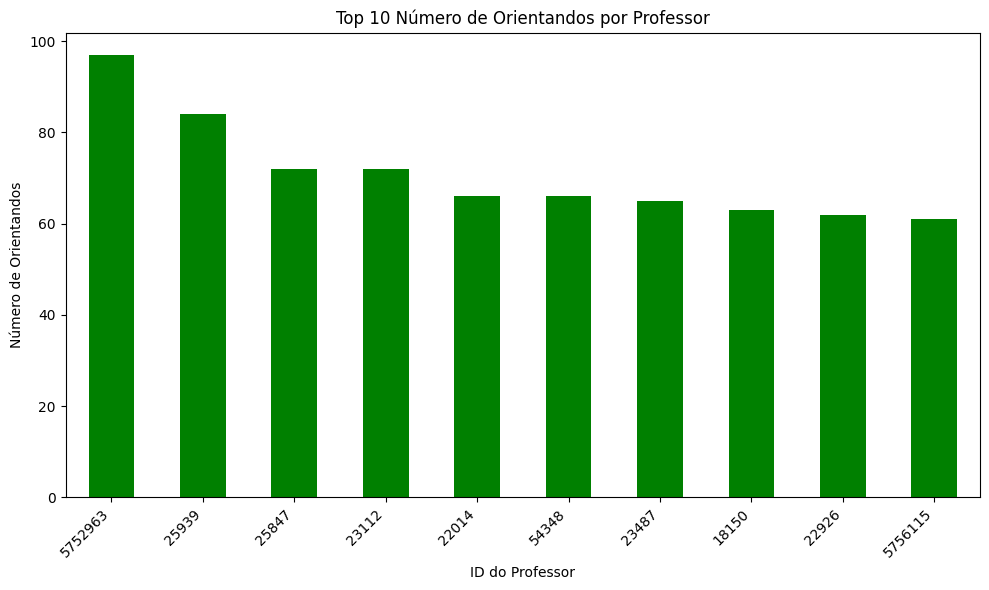

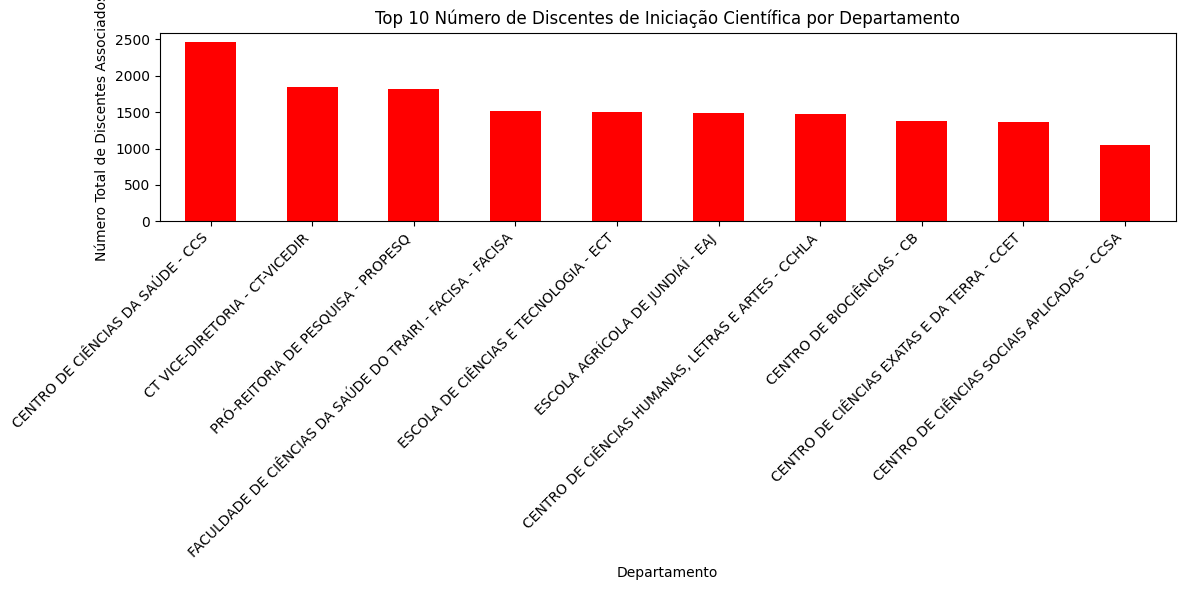

In [ ]:
# Análise gráfica dos resultados

import matplotlib.pyplot as plt
import pandas as pd

if 'contagem_discentes_por_orientador' in locals() and 'contagem_discentes_por_departamento' in locals():

    # Gráfico 1: Top N Professores por número de Orientandos
    # Converter o dicionário para Series para facilitar a ordenação e seleção
    serie_orientadores_discentes = pd.Series(contagem_discentes_por_orientador)

    # Pegar os top N (vamos usar 10 como exemplo, pode ajustar)
    top_n = 10
    top_orientadores = serie_orientadores_discentes.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    top_orientadores.plot(kind='bar', color='green')
    plt.title(f'Top {top_n} Número de Orientandos por Professor')
    plt.xlabel('ID do Professor')
    plt.ylabel('Número de Orientandos')
    plt.xticks(rotation=45, ha='right') # Rotação para IDs longos
    plt.tight_layout() # Ajusta o layout para evitar cortes
    plt.show()

    # Espaço entre os gráficos
    print()

    # Gráfico 2: Top N Departamentos por número de Discentes
    # Converter o dicionário para Series
    serie_departamentos_discentes = pd.Series(contagem_discentes_por_departamento)

    # Pegar os top N (vamos usar 10 como exemplo, pode ajustar)
    top_departamentos = serie_departamentos_discentes.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(12, 6))
    top_departamentos.plot(kind='bar', color='red')
    plt.title(f'Top {top_n} Número de Discentes de Iniciação Científica por Departamento')
    plt.xlabel('Departamento')
    plt.ylabel('Número Total de Discentes Associados')
    plt.xticks(rotation=45, ha='right') # Rotação para nomes longos
    plt.tight_layout()
    plt.show()

else:
    print("As variáveis de contagem de discentes por orientador/departamento não foram encontradas. Por favor, execute as células de análise primeiro.")